In [1]:
!pip install --upgrade scikit-learn

In [2]:
import spacy_transformers

In [3]:
import re
import spacy
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import rand_score, v_measure_score, adjusted_rand_score
import seaborn as sns
from pprint import pprint

In [4]:
occasion_factor = 0.5

In [5]:
df = pd.read_csv('amazon.csv', usecols=['product_name', 'about_product', 'discounted_price', 'discount_percentage', 'category'])

names = df['product_name'].to_numpy()
abouts = df['about_product'].to_numpy()
for i in range(len(df)):
    abouts[i] = names[i] + ";" + abouts[i]
prices = df['discounted_price'].to_numpy()
percentage = df['discount_percentage'].to_numpy()
categories = df['category'].tolist()

In [6]:
NER = spacy.load('en_core_web_sm')

In [7]:
products_named_entities = []
for i in range(len(abouts)):
    ents = [word.text for word in NER(abouts[i]).ents]
    representations = names[i] + ' '.join(ents)
    products_named_entities.append(representations)


In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_documents = vectorizer.fit_transform(products_named_entities)


In [9]:
clustering = AgglomerativeClustering(metric='cosine', linkage='average', distance_threshold=0.5, compute_full_tree=True, n_clusters=None)
clustering.fit(vectorized_documents.toarray())
results = clustering.labels_

In [10]:
num_clusters = clustering.n_clusters_
num_clusters

928

In [11]:
clusters = [[] for i in range(num_clusters)]
for i in range(len(df)):
    price = prices[i]
    price = re.sub("[^0-9.]", "", price)
    clusters[results[i]].append({"price": float(price), "name": names[i]})

averages = [0]*num_clusters
for i in range(len(clusters)):
    cluster = clusters[i]
    for j in range(len(cluster)):
        element = cluster[j]
        averages[i] = averages[i] + element["price"]
    averages[i] = averages[i]/len(clusters[i])

for i in range(len(clusters)):
    cluster = clusters[i]
    for j in range(len(cluster)):
        element = cluster[j]
        if element["price"] < occasion_factor*averages[i]:
            print(element)


{'price': 199.0, 'name': 'Smashtronics® - Case for Firetv Remote, Fire Stick Remote Cover Case, Silicone Cover for TV Firestick 4K/TV 2nd Gen(3rd Gen) Remote Control - Light Weight/Anti Slip/Shockproof (Black)'}
{'price': 199.0, 'name': 'Smashtronics® - Case for Firetv Remote, Fire Stick Remote Cover Case, Silicone Cover for TV Firestick 4K/TV 2nd Gen(3rd Gen) Remote Control - Light Weight/Anti Slip/Shockproof (Black)'}
{'price': 210.0, 'name': 'Sui Generis Electric Handheld Milk Wand Mixer Frother for Latte Coffee Hot Milk, Milk Frother, Electric Coffee Beater, Egg Beater, Latte Maker, Mini Hand Blender Cappuccino Maker (Multicolor)'}
{'price': 249.0, 'name': 'REDTECH USB-C to Lightning Cable 3.3FT, [Apple MFi Certified] Lightning to Type C Fast Charging Cord Compatible with iPhone 14/13/13 pro/Max/12/11/X/XS/XR/8, Supports Power Delivery - White'}
{'price': 378.0, 'name': "Portronics Ruffpad 8.5M Multicolor LCD Writing Pad with Screen 21.5cm (8.5-inch) for Drawing, Playing, Handwriti

In [12]:
pprint(clusters[0])

[{'name': 'Tizum High Speed HDMI Cable with Ethernet | Supports 3D 4K | for '
          'All HDMI Devices Laptop Computer Gaming Console TV Set Top Box (1.5 '
          'Meter/ 5 Feet)',
  'price': 199.0},
 {'name': 'Amazon Basics High-Speed HDMI Cable, 6 Feet - Supports Ethernet, '
          '3D, 4K video,Black',
  'price': 309.0},
 {'name': 'Amazon Basics High-Speed HDMI Cable, 6 Feet (2-Pack),Black',
  'price': 309.0},
 {'name': 'Amazon Basics HDMI Coupler,Black', 'price': 209.0},
 {'name': 'AmazonBasics High-Speed Braided HDMI Cable - 3 Feet - Supports '
          'Ethernet, 3D, 4K and Audio Return (Black)',
  'price': 269.0},
 {'name': 'Tizum High Speed HDMI Cable with Ethernet | Supports 3D 4K | for '
          'All HDMI Devices Laptop Computer Gaming Console TV Set Top Box (1.5 '
          'Meter/ 5 Feet)',
  'price': 199.0}]


In [13]:
distance_thresholds = []
rand_scores = []
v_measures = []
adjusted_rand_scores = []
linkages = []
metrics = []
for metric in ['euclidean', 'cosine', 'manhattan', 'l1', 'l2']:
    for linkage in ['single', 'complete', 'average']:
        for distance_threshold in np.linspace(0, 1, 11):
            clustering = AgglomerativeClustering(metric=metric, linkage=linkage, distance_threshold=distance_threshold, compute_full_tree=True, n_clusters=None)
            clustering.fit(vectorized_documents.toarray())
            results = clustering.labels_
            metrics.append(metric)
            linkages.append(linkage)
            rand_scores.append(rand_score(results, categories))
            v_measures.append(v_measure_score(results, categories))
            adjusted_rand_scores.append(adjusted_rand_score(results, categories))
            distance_thresholds.append(distance_threshold)


In [14]:
metrics_df = pd.DataFrame({
    'distance_thresholds': distance_thresholds,
    'rand_scores': rand_scores,
    'v_measures': v_measures,
    'adjusted_rand_scores': adjusted_rand_scores,
    'linkages': linkages,
    'metrics': metrics
})

In [15]:
from matplotlib import pyplot as plt
import random
plt.rcParams["figure.figsize"] = (20,10)

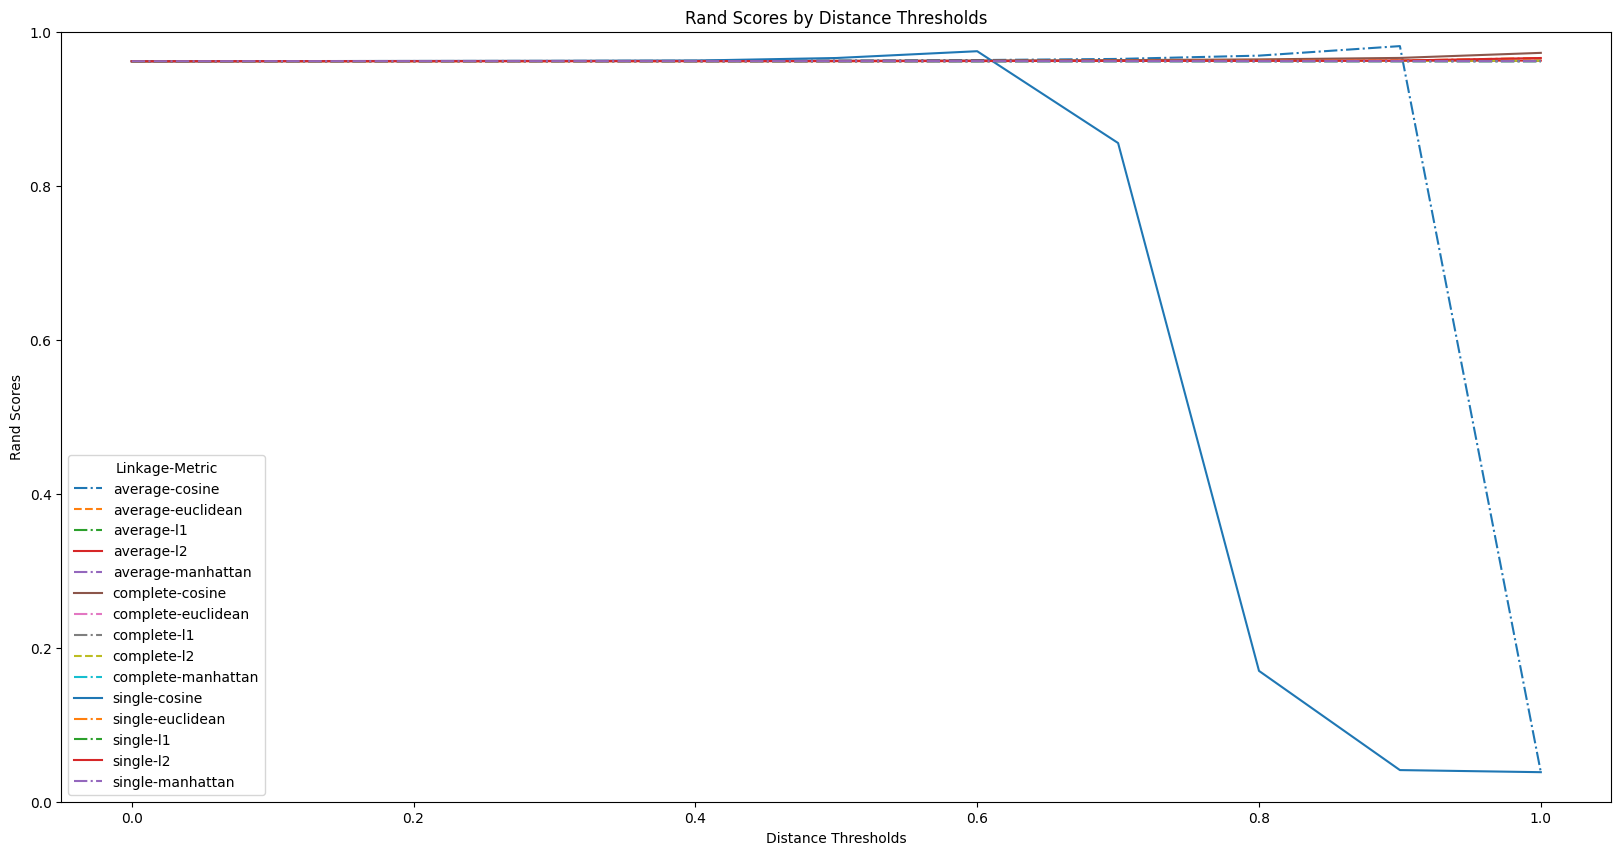

In [16]:
fig, ax = plt.subplots()

grouped = metrics_df.groupby(['linkages', 'metrics'])
line_styles = ['dashed', 'solid', 'dotted', 'dashdot']

for style_num, ((linkage, metric), group) in enumerate(grouped):
    sns.lineplot(x='distance_thresholds', y='rand_scores', data=group, label=f'{linkage}-{metric}', ax=ax, linestyle=random.choice(line_styles))

ax.set_title('Rand Scores by Distance Thresholds')
ax.set_xlabel('Distance Thresholds')
ax.set_ylabel('Rand Scores')
ax.set_ylim(0, 1)

plt.legend(title='Linkage-Metric')
plt.show()

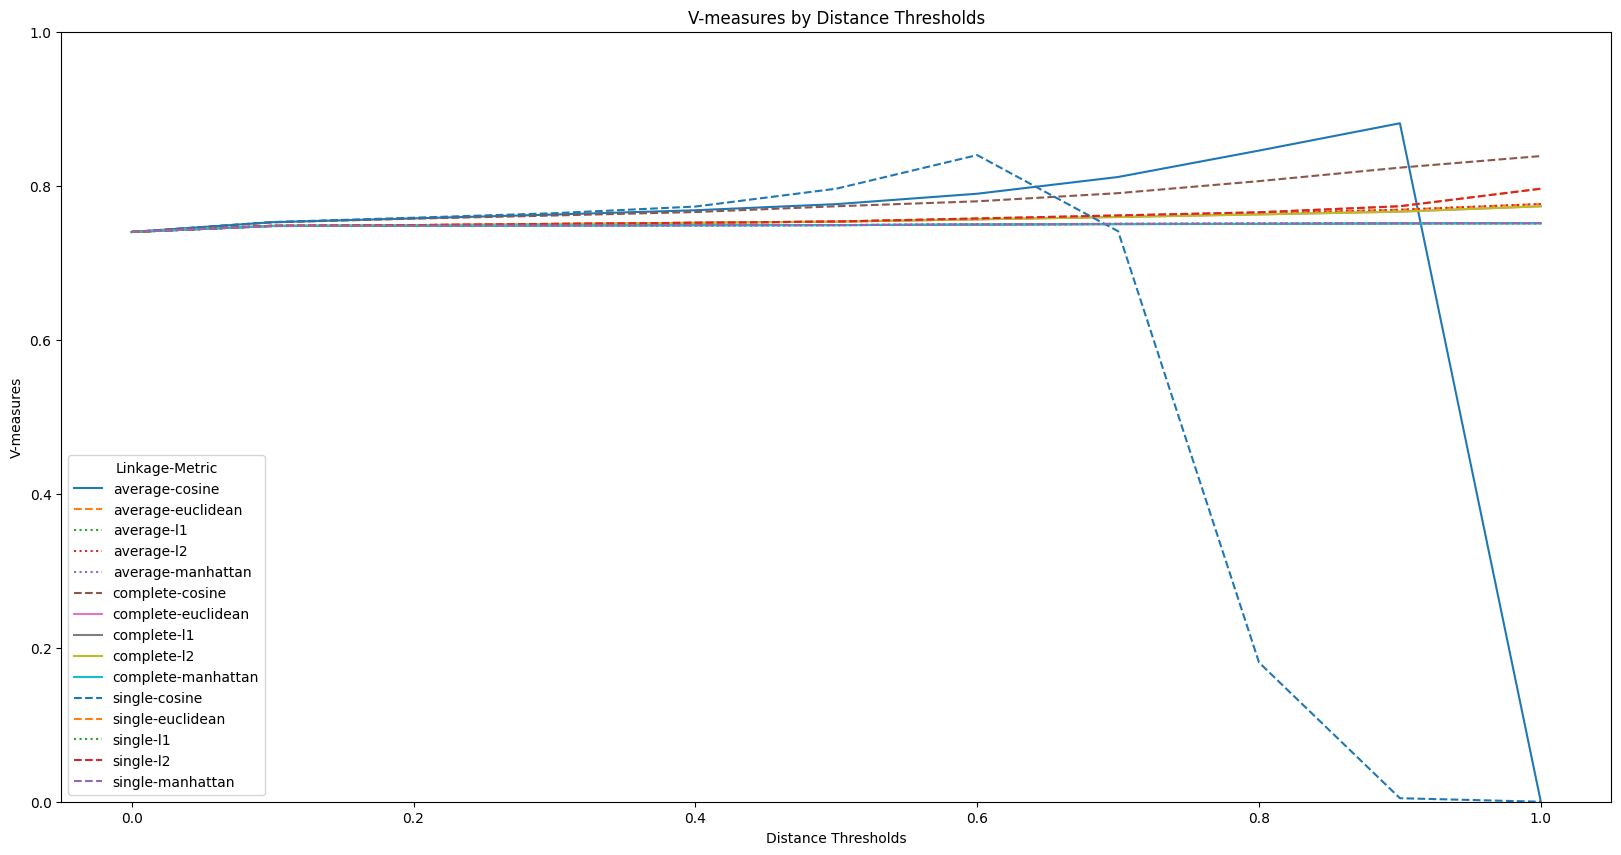

In [17]:
fig, ax = plt.subplots()

grouped = metrics_df.groupby(['linkages', 'metrics'])
line_styles = ['dashed', 'solid', 'dotted', 'dashdot']

for style_num, ((linkage, metric), group) in enumerate(grouped):
    sns.lineplot(x='distance_thresholds', y='v_measures', data=group, label=f'{linkage}-{metric}', ax=ax, linestyle=random.choice(line_styles))

ax.set_title('V-measures by Distance Thresholds')
ax.set_xlabel('Distance Thresholds')
ax.set_ylabel('V-measures')
ax.set_ylim(0, 1)

plt.legend(title='Linkage-Metric')
plt.show()

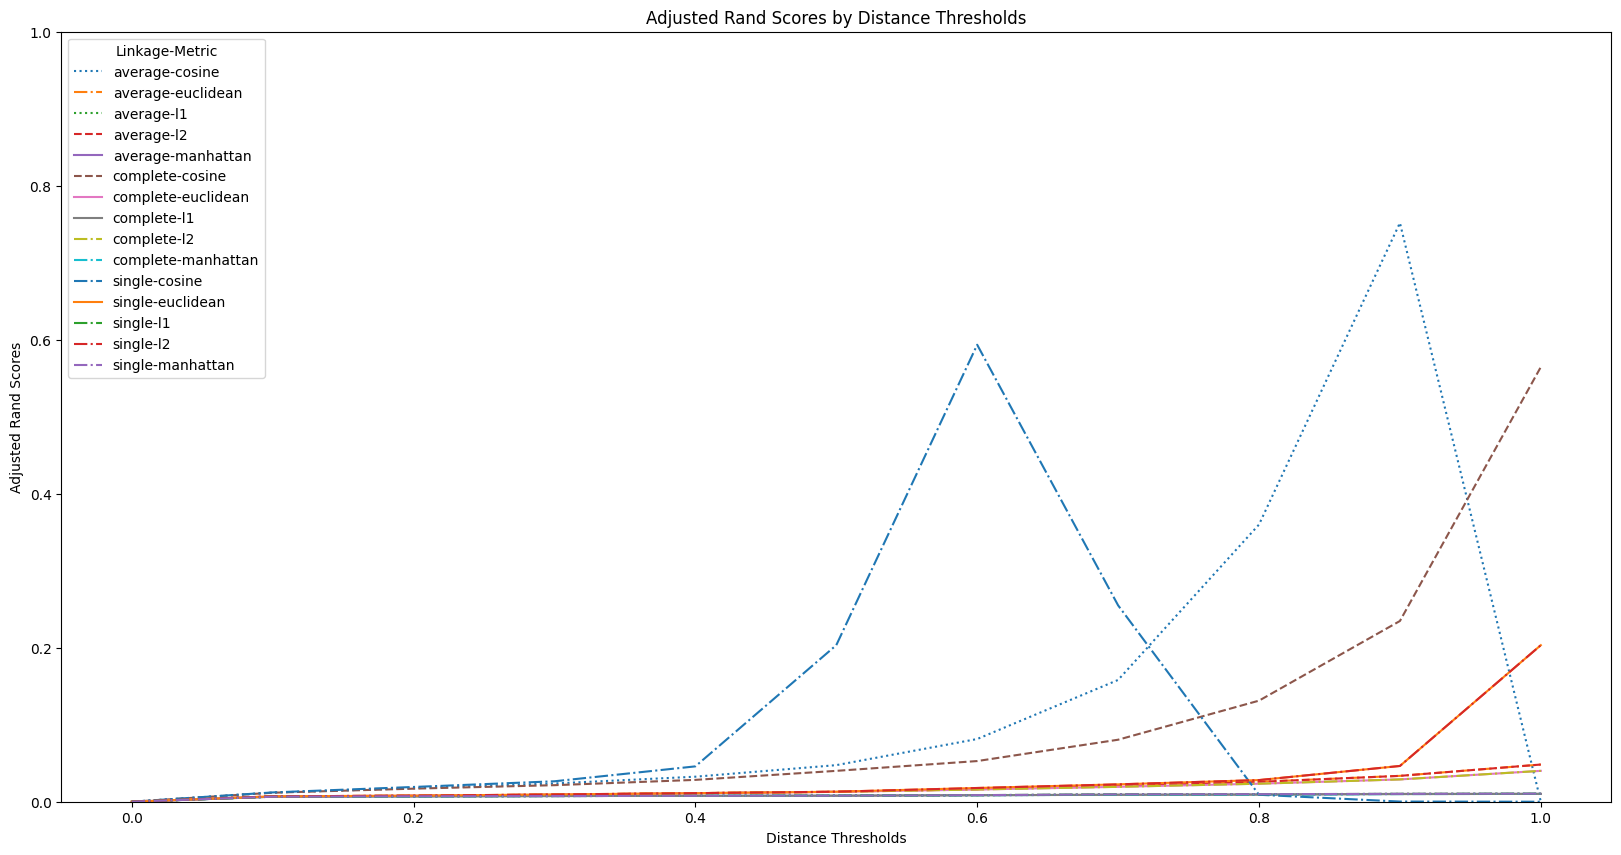

In [18]:
fig, ax = plt.subplots()

grouped = metrics_df.groupby(['linkages', 'metrics'])
line_styles = ['dashed', 'solid', 'dotted', 'dashdot']

for style_num, ((linkage, metric), group) in enumerate(grouped):
    sns.lineplot(x='distance_thresholds', y='adjusted_rand_scores', data=group, label=f'{linkage}-{metric}', ax=ax, linestyle=random.choice(line_styles))

ax.set_title('Adjusted Rand Scores by Distance Thresholds')
ax.set_xlabel('Distance Thresholds')
ax.set_ylabel('Adjusted Rand Scores')
ax.set_ylim(0, 1)

plt.legend(title='Linkage-Metric')
plt.show()

In [19]:
metrics_df

,distance_thresholds,rand_scores,v_measures,adjusted_rand_scores,linkages,metrics
0,0.0,0.961636,0.739916,0.000000,single,euclidean
1,0.1,0.961776,0.748036,0.006989,single,euclidean
2,0.2,0.961792,0.748823,0.007869,single,euclidean
3,0.3,0.961824,0.750482,0.009445,single,euclidean
4,0.4,0.961855,0.751874,0.011105,single,euclidean
...,...,...,...,...,...,...
160,0.6,0.961957,0.756584,0.016265,average,l2
161,0.7,0.962033,0.759961,0.020205,average,l2
162,0.8,0.962145,0.764131,0.025820,average,l2
163,0.9,0.962288,0.768789,0.033582,average,l2


In [20]:
for (linkage, metric), group in grouped:
    print(group)


    distance_thresholds  rand_scores  v_measures  adjusted_rand_scores  \
55                  0.0     0.961636    0.739916              0.000000   
56                  0.1     0.961870    0.752639              0.011889   
57                  0.2     0.961982    0.757584              0.017507   
58                  0.3     0.962102    0.762594              0.023721   
59                  0.4     0.962265    0.768131              0.032496   
60                  0.5     0.962535    0.776095              0.047501   
61                  0.6     0.963176    0.789603              0.081425   
62                  0.7     0.964658    0.811330              0.158146   
63                  0.8     0.968949    0.845632              0.359959   
64                  0.9     0.981317    0.881096              0.751750   
65                  1.0     0.038364    0.000000              0.000000   

   linkages metrics  
55  average  cosine  
56  average  cosine  
57  average  cosine  
58  average  cosine  
5